In [60]:
%matplotlib notebook

project > solve > solving system using sparse direct solver
project > constrained 25/1420 dofs, error 0.00e+00/area
project > constrained 25/1420 dofs, error 0.00e+00/area
project > constrained 50/1420 dofs, error 0.00e+00/area
project > constrained 50/1420 dofs, error 0.00e+00/area
solve > solving system using sparse direct solver
elem_eval > created ndarray(2304,2), ndarray(2304)


<IPython.core.display.Javascript object>


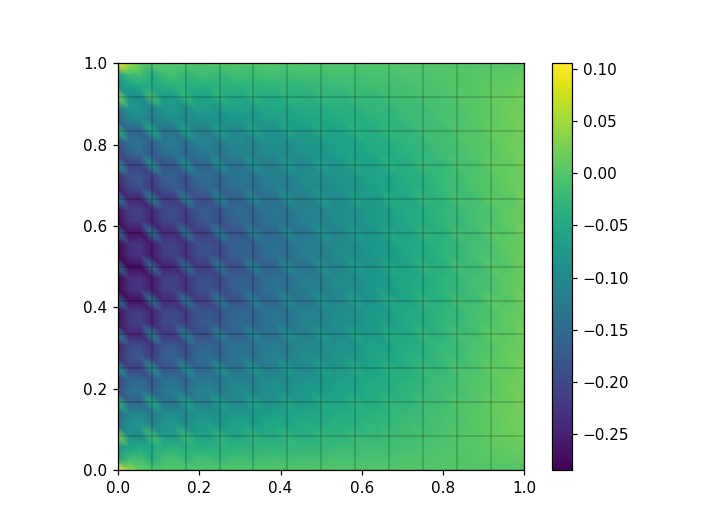

In [81]:
import numpy as np
from nutils import *

# define problem parameters
nelems  = 12
ischeme = 'gauss3'
degree = 2

# construct topology, geometry and basis
verts = np.linspace(0,1, nelems+1)
domain, geom = mesh.rectilinear([verts, verts])

# construct namespace
mult = [degree+1] + [degree]*(nelems-1) + [degree+1]
ns = function.Namespace()
ns.x = geom
ns.phi = domain.basis('spline', degree=2, knotmultiplicities=(mult,mult)).vector(2)
ns.psi = domain.basis('spline', degree=1)
ns.phi, ns.psi, ns.lagrange = function.chain([ns.phi, ns.psi, [1]])
ns.eye    = numpy.array([[1,0],[0,1]])
ns.lmbda  = 1
ns.mu     = 1
# ns.symPhi = '(basis_ni,j + basis_nj,i) / 2'
# ns.stress_nij = 'lmbda strain_nkk eye_ij + 2 mu strain_nij'

# construct matrix
A = domain.integrate(
    ns.eval_ij('phi_ik,l phi_jk,l'),
    geometry=geom, ischeme=ischeme)
D = domain.integrate(
    ns.eval_ij('phi_ik,k psi_j'),
    geometry=geom, ischeme=ischeme)
L = domain.integrate(
    ns.eval_ij('lagrange_i psi_j'),
    geometry=geom, ischeme=ischeme)

# construct dirichlet boundary constraints
cons1 = domain.boundary['left'].project(
    'x_1 (1 - x_1)'@ns, onto='phi_ni n_i'@ns, geometry=geom, ischeme=ischeme)
cons2 = domain.boundary['left'].project(
    0, onto='phi_n1'@ns, geometry=geom, ischeme=ischeme)
cons3 = domain.boundary['top'].project(
    0, onto=ns.phi, geometry=geom, ischeme=ischeme)
cons4 = domain.boundary['bottom'].project(
    0, onto=ns.phi, geometry=geom, ischeme=ischeme)
# cons4 = domain.integrate(
#     0, onto=ns.phi, geometry=geom, ischeme=ischeme)
# cons2 = domain.boundary['right'].project(
#     0.5, onto=ns.eval_n('basis_ni n_i'), geometry=geom, ischeme=ischeme)
cons = cons1 | cons2 | cons3 | cons4

bigA = A + D + D.T + L + L.T

# solve linear system
ns.w = bigA.solve(constrain=cons)

# # construct the solution
ns.u = 'phi_n0 w_n'
ns.v = 'phi_n1 w_n'
ns.p = 'psi_n w_n'

# # plot
points, colors = domain.elem_eval( [geom, 'u'@ns], ischeme='bezier4', separate=True)
plt = plot.PyPlot()
plt.mesh(points, colors)
plt.colorbar()

In [54]:
from scipy import linalg
B = A.toscipy()
e = linalg.eig(B.todense())
er = e[0].real
er = np.sort(er)

In [49]:
er[:5]

array([-7.38344331e-16, -6.65601554e-16,  1.03360273e-15,  1.04585937e-15,
        2.60468963e-03])

In [45]:
print(mult)

[3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3]


In [50]:
print(e)

(array([2.65523013+0.j, 2.61827414+0.j, 2.63806519+0.j, ...,
       0.23477884+0.j, 0.24947055+0.j, 0.23767182+0.j]), array([[ 2.41180484e-04, -8.42742508e-04,  6.38210451e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 5.82594577e-04, -2.18124167e-03,  1.59493446e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.16782532e-04, -3.14315232e-03,  2.13153108e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.67234063e-04, -3.35323011e-03, -7.53561043e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.46901003e-02,  2.87692789e-03,  5.41446637e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.10922798e-02, -8.32725824e-15, -8.72750417e-16]]))


In [55]:
print(A.shape)

(1419, 1419)


In [56]:
print(D.shape)

(1419, 1419)


In [65]:
print(cons)

[ 1.38777878e-17 -4.16666667e-02 -1.11111111e-01 -1.66666667e-01
 -2.08333333e-01 -2.36111111e-01 -2.50000000e-01 -2.50000000e-01
 -2.36111111e-01 -2.08333333e-01 -1.66666667e-01 -1.11111111e-01
 -4.16666667e-02  4.53502492e-17  0.00000000e+00             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  0.00000000e+00
  0.00000000e+00             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan  0.00000000e+00  0.00000000e+00             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan  0.00000000e+00
  0.00000000e+00             nan             nan             nan
             nan         